In [645]:
import pandas as pd
import numpy as np
import sys, os,collections
import pickle
import glob
from gensim import corpora, models, similarities
from gensim.models.ldamulticore import LdaMulticore,LdaModel
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import common_corpus, common_dictionary
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler


In [10]:
path = '/home/sdeng/data/icews/events.1991.201703.country/icews_events_THA.json'
df = pd.read_json(path,lines=True)
print(len(df))


217144


In [45]:
df_clean = df.drop_duplicates(subset=['Country', 'CAMEO Code', 'Event Date', 'Story ID',  'Sentence Number','Source Name','Target Name' ])
df_clean.drop(columns=['Longitude', 'Latitude','Source Country','Target Country','Publisher','Target Sectors','Source Sectors','Intensity'],inplace=True)

print('df_clean',len(df_clean))

def getRoot(x):
    x = int(x)
    if len(str(x)) == 4: # 1128
        return x // 100
    elif len(str(x)) == 3:
        if x // 10 < 20: # 190
            return x // 10
        else:
            return x // 100
    else:
        return x // 10
    
df_clean['root'] = df_clean['CAMEO Code'].apply(lambda x: getRoot(x) )
print(df_clean.columns)


/home/sdeng/anaconda2/envs/jupyter/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


df_clean 217062
Index(['Province', 'District', 'City', 'Country', 'CAMEO Code', 'Target Name',
       'Event Date', 'Source Name', 'Story ID', 'Event Text',
       'Sentence Number', 'Event ID', 'root'],
      dtype='object')


/home/sdeng/anaconda2/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [46]:
df_has_city = df_clean.loc[df_clean['City']!='']

In [54]:
df_has_city['City'].value_counts()[-400:]

San Sai              6
Ban Na Pradu         6
Ban Tha Ruea         6
Thai Mueang          6
Wiphawadi            6
                    ..
Chom Bueng           1
Om Koi               1
Doi Saket            1
Nam Pong             1
Ban Su-ngai Pa Di    1
Name: City, Length: 400, dtype: int64

In [105]:
# df_remove_dup['Province'].value_counts()
# len(df_remove_dup)
df_has_city

,Province,District,City,Country,CAMEO Code,Target Name,Event Date,Source Name,Story ID,Event Text,Sentence Number,Event ID,root
2,Krung Thep Mahanakhon,,Bangkok,Thailand,10,Military (Thailand),1991-01-08,Thailand,28527478,Make statement,2,659,1
3,Krung Thep Mahanakhon,,Bangkok,Thailand,111,Chatichai Choonhavan,1991-01-10,Opposition Supporter (Thailand),28527320,Criticize or denounce,4,1211,11
4,Krung Thep Mahanakhon,,Bangkok,Thailand,173,Criminal (Thailand),1991-01-13,Thailand,28530311,"Arrest, detain, or charge with legal action",2,1915,17
5,Krung Thep Mahanakhon,,Bangkok,Thailand,214,Chatichai Choonhavan,1991-01-18,People Associated with the Opposition (Thailand),28527202,Appeal for intelligence,2,2328,2
6,Krung Thep Mahanakhon,,Bangkok,Thailand,10,Cabinet / Council of Ministers / Advisors (Tha...,1991-01-21,Other Authorities / Officials (Thailand),28528064,Make statement,1,2576,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
217139,Changwat Nakhon Phanom,,Nakhon Phanom,Thailand,43,Gen Prayut Chan-o-cha,2017-03-27,Thailand,43831402,Host a visit,1,27405381,4
217140,Changwat Nakhon Phanom,,Nakhon Phanom,Thailand,10,Government (Thailand),2017-03-27,Head of Government (Thailand),43831402,Make statement,1,27405379,1
217141,Changwat Nakhon Phanom,,Nakhon Phanom,Thailand,42,Thailand,2017-03-27,Gen Prayut Chan-o-cha,43831402,Make a visit,1,27405380,4
217142,Krung Thep Mahanakhon,,Bangkok,Thailand,50,Thailand,2017-03-27,China,43831443,Engage in diplomatic cooperation,4,27405345,5


In [42]:
city_list = df_has_city['City'].unique()
# city_list



In [112]:
city_list[:10]

array(['Bangkok', 'Ratchaburi', 'Khon Kaen', 'Krabi', 'Chiang Mai',
       'Nakhon Pathom', 'Phra Khanong', 'Suphan Buri', 'Phatthaya',
       'Lamphun'], dtype=object)

In [114]:
window = 14
horizon = 7
start_year = 2010
for city in city_list[-400:]:
    
    df_city = df_has_city.loc[df_has_city['City'] == city]
    date_list = df_city['Event Date'].unique()
    if len(date_list) <= 1:
        continue
#     print(city, len(df_city))
#     print(date_list)
    for day in date_list:
        if day > '2017-03-20' or day < '{}-01-01'.format(start_year):
            print('day',city,day)
            continue
        continue
        r = dict()
        # get previous 7 days and next 7 days
        prev_dates = list(pd.date_range(end=day, periods=window, closed=None).strftime('%Y-%m-%d'))
#         print('prev_dates',prev_dates)
        story_list = []
        for d in prev_dates:
            df_prev = df_city.loc[df_city['Event Date'] == d]
            storyid = df_prev['Story ID'].unique()
            story_list.append(list(storyid))
#             print('storyid',storyid)
#         print('story_list',story_list)
#         df_prev = df_city.loc[df_city['Event Date'].isin(prev_dates)]
#         print('past days that have data',df_prev['Event Date'].unique())
#         print(df_prev)
        # get story id in the past
#         prev_story = df_prev['Story ID'].unique()
#         print(prev_story)
        # save news article
        r['story_list'] = story_list
        r['city'] = city
        r['date'] = day # treatment day
        
        
        next_dates = list(pd.date_range(start=day, periods=horizon+1, closed='right').strftime('%Y-%m-%d'))
        df_next_all = df_city.loc[df_city['Event Date'].isin(next_dates)]
        r['event_count'] = df_next_all['root'].value_counts().to_dict() # next 7 days
#         print('next_dates',next_dates,df_next_all.empty)
        if df_next_all.empty:
            r['event_ids'] = [[] for i in range(horizon)]
        else:
            event_list = []
            for d in next_dates:
                df_next = df_city.loc[df_city['Event Date'] == d]
#                 print(df_next['Event ID'])
                event_list.append(df_next['Event ID'].unique())
            r['event_ids'] = event_list
#         df_next = df_city.loc[df_city['Event Date'].isin(next_dates)]
#         print('future days that have data',df_next['Event Date'].unique())
#         print(r)
#     break
    

day Victory Monument 2001-07-15
day Victory Monument 2004-08-08
day Victory Monument 2005-05-11
day Victory Monument 2005-06-24
day Victory Monument 2006-12-01
day Victory Monument 2006-12-31
day Victory Monument 2007-01-02
day Victory Monument 2007-05-09
day Victory Monument 2007-08-10
day Victory Monument 2008-01-21
day Victory Monument 2008-02-05
day Victory Monument 2009-04-09
day Victory Monument 2009-04-10
day Victory Monument 2009-04-11
day Victory Monument 2009-04-13
day Victory Monument 2009-04-14
day Victory Monument 2009-04-15
day Victory Monument 2009-04-16
day Victory Monument 2009-04-24
day Victory Monument 2009-06-10
day Victory Monument 2009-10-14
day Jomtien 2001-07-30
day Jomtien 2002-04-03
day Jomtien 2007-02-27
day Jomtien 2007-03-07
day Lom Sak 2001-08-14
day Lom Sak 2002-08-12
day Lom Sak 2005-11-22
day Lom Sak 2005-11-24
day Lom Sak 2009-09-11
day Lom Sak 2009-10-09
day Watthana 2001-08-18
day Watthana 2005-02-13
day Watthana 2005-07-13
day Watthana 2008-12-14
da

day Waeng 2004-04-10
day Waeng 2004-07-05
day Waeng 2004-09-17
day Waeng 2004-10-14
day Waeng 2004-11-20
day Waeng 2004-11-23
day Waeng 2005-01-10
day Waeng 2005-04-13
day Waeng 2005-07-23
day Waeng 2005-12-21
day Waeng 2007-03-10
day Waeng 2007-03-11
day Waeng 2007-05-24
day Waeng 2009-02-16
day Waeng 2009-07-01
day Waeng 2009-12-14
day Waeng 2009-12-25
day Yaring 2004-04-20
day Yaring 2004-08-05
day Yaring 2004-09-19
day Yaring 2004-11-23
day Yaring 2004-11-28
day Yaring 2004-11-29
day Yaring 2004-12-02
day Yaring 2004-12-09
day Yaring 2004-12-20
day Yaring 2005-02-14
day Yaring 2005-04-23
day Yaring 2005-05-20
day Yaring 2005-05-21
day Yaring 2005-06-07
day Yaring 2005-06-17
day Yaring 2005-06-21
day Yaring 2005-06-25
day Yaring 2005-06-28
day Yaring 2005-07-13
day Yaring 2005-09-16
day Yaring 2005-09-21
day Yaring 2005-10-06
day Yaring 2005-10-10
day Yaring 2005-10-31
day Yaring 2005-11-01
day Yaring 2006-03-06
day Yaring 2006-03-07
day Yaring 2006-03-08
day Yaring 2006-03-31
day Y

day Satuek 2005-02-03
day Satuek 2009-03-08
day Satuek 2009-03-09
day Ban Dung 2005-02-10
day Pho Thong 2005-02-15
day Pho Thong 2005-02-16
day Pho Thong 2006-10-23
day Ban Nam Khem 2005-02-19
day Ban Nam Khem 2005-02-20
day Ban Nam Khem 2005-05-02
day Ban Nam Khem 2005-06-23
day Ban Nam Khem 2007-12-27
day Ban Nang Sata 2005-02-25
day Ban Nang Sata 2006-02-02
day Mae Nam Ping 2005-03-14
day Mae Nam Ping 2005-10-01
day Mae Nam Ping 2006-07-08
day Mae Nam Ping 2006-07-11
day Laplae 2005-04-09
day Laplae 2006-06-05
day Bang Rakam 2005-04-18
day Kong Ra 2005-04-18
day Kong Ra 2005-04-20
day Mayo 2005-04-19
day Mayo 2005-04-20
day Mayo 2005-06-03
day Mayo 2005-11-25
day Mayo 2007-09-15
day Mayo 2008-09-29
day Mayo 2009-07-28
day Mayo 2009-10-27
day Klaeng 2005-05-08
day Kaeng Khoi 2005-05-15
day Sathon 2005-05-16
day Sathon 2005-12-08
day Sathon 2006-03-22
day Sathon 2009-09-03
day Su-ngai Padi 2005-05-18
day Su-ngai Padi 2005-09-26
day Su-ngai Padi 2007-03-22
day Su-ngai Padi 2007-03-23
d

In [150]:
# list(pd.date_range(end='2010-01-01', periods=window, closed=None))
event_path = "/home/sdeng/data/icews/detailed_event_json/THA_2010_w14h7_city.json"
out_path = "../data"
country = event_path.split('/')[-1][:3]
dataset = country + '_topic'
window = 14
horizon = 7

In [122]:
dataset_path = "{}/{}".format(out_path,dataset)
os.makedirs(dataset_path, exist_ok=True)

In [123]:
df = pd.read_json(event_path,lines=True)

In [124]:
 
news_df = pd.read_json('/home/sdeng/data/icews/news.1991.201703.country/icews_news_{}.json'.format(country), lines=True)

In [143]:
news_df[['Date','PublishDate']]
# for i,row in news_df.iterrows():
#     if row['Date']!=row['PublishDate']:
#         print('Date {}  \t PublishDate {}'.format(str(row['Date']),row['PublishDate']))
story_list = df.iloc[0]['story_list']
story_list

[[],
 [],
 [10644052],
 [10650272, 13115480, 13115486],
 [10656374, 10656810, 10658594, 10659182, 13116199],
 [],
 [],
 [],
 [],
 [],
 [],
 [9874475],
 [9879799, 11672446, 11672584, 11673095],
 [7532345]]

In [144]:
story_list = df.iloc[0]['story_list'][14-7:]
print(story_list)
story_list = [item for sublist in story_list for item in sublist]

[[], [], [], [], [9874475], [9879799, 11672446, 11672584, 11673095], [7532345]]


In [266]:
# list(set(story_list))
# np
raw_covariates = []
raw_outcomes = []
for i,row in df.iterrows():
    story_list = row['story_list'][14-window:]
    story_list = [item for sublist in story_list for item in sublist]
    story_list = list(set(story_list))
    if len(story_list) <= 0:
        continue # no story id
#     print(story_list)
    text_df = news_df.loc[news_df['StoryID'].isin(story_list)]
    if text_df.empty:
        continue # no text
    text_list = text_df['Text'].values
#     print(text_list)
#     processed_tokens = clean_document_list(story_l)
    processed_tokens = [['crime', 'business','transnational','crime','suppression','csd','stepping','effort','seek','cooperation','foreign','embassy','embassy','criminal','coming','country'],
                        ['hitman', 'business', 'transnational', 'crime', 'suppression','csd', 'stepping', 'effort', 'seek','cooperation', 'foreign', 'embassy', 'embassy','criminal','coming', 'country']]
    
    corpus_bow = [loaded_dict.doc2bow(text) for text in processed_tokens]
#     print(corpus_bow)
    r =  loaded_lda.get_document_topics(corpus_bow,per_word_topics=False,minimum_probability=0.01)
    topic_ids = []
    topic_vec = np.zeros(50)
    for j in range(len(r)):
        topic_id = [a_tuple[0] for a_tuple in r[j]]
        topic_ids += topic_id
    topic_count = collections.Counter(topic_ids)
#     print(topic_ids)
    for k in topic_count:
        topic_vec[k] = topic_count[k]
    
    # output 
    event_vec = np.zeros(20)
    event_count = row['event_count']
#     print(event_count)
    for k in event_count:
        event_vec[int(k)-1] = event_count[k]
    
    print(event_vec)
    print(topic_vec)
    raw_covariates.append(topic_vec)
    raw_outcomes.append(event_vec)
    
#     for 
    if i == 2:
        break
    
    

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 2. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0.
 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 2. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 9. 4. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 2. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0.
 0. 0.]


In [265]:
raw_covariates = np.stack(raw_covariates,0)
raw_outcomes = np.stack(raw_outcomes,0)
raw_outcomes

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 2., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 9., 4., 0.]])

(21, 50)

In [164]:
lda_name = 'THA_50'

loaded_dict = corpora.Dictionary.load('/home/sdeng/data/icews/topic_models/{}.dict'.format(country))
loaded_lda =  models.LdaModel.load('/home/sdeng/data/icews/topic_models/{}.lda'.format(lda_name))

# from text_src.text_utils import *


ModuleNotFoundError: No module named 'text_src'

In [249]:
# # r[0]
# a = np.array([0,0,0])
# d = collections.Counter([2,2,1,2,2,2,2])
# print(d)
# for k in d:
#     a[k] = d[k]
# a
def getRoot(x):
    x = int(x)
    print(x)
    if len(str(x)) == 4: # 1128
        return x // 100
    elif len(str(x)) == 3:
        if x // 10 <= 20: # 190
            return x // 10
        else:
            return x // 100
    else:
        return x // 10
    
getRoot(104)

# path = "/home/sdeng/data/icews/events.1991.201703.country/icews_events_{}.json".format(country)
# event_df = pd.read_json(path,lines=True)

104


10

In [258]:
# event_df['root'] = event_df['CAMEO Code'].apply(lambda x: getRoot(x))
def get_cameo_main(code):
    code = int(code)
    if code < 100:
        return code // 10
    if code // 10 > 20:
        return code // 100
    else:
        return code // 10
get_cameo_main(212)

2

In [235]:
event_df[['CAMEO Code','root']].value_counts()
event_df.loc[event_df['CAMEO Code']==202]

,Province,Publisher,Source Country,District,City,Country,CAMEO Code,Target Name,Source Sectors,Event Date,...,Target Sectors,Intensity,Story ID,Latitude,Event Text,Longitude,Target Country,Sentence Number,Event ID,root
12109,Chiang Mai Province,Bangkok Post,Thailand,,Chiang Mai,Thailand,202,Villager (Thailand),"Criminals / Gangs,Dissident",1999-04-11,...,"General Population / Civilian / Social,Social",-10.0,29951280,18.79040,Engage in mass killings,98.9847,Thailand,5,1394020,2
47446,Changwat Pattani,The Nation (Thailand),Thailand,,Pattani,Thailand,202,Muslim (Thailand),"Military,Government",2004-07-26,...,"Muslim,Social,National Religious,International...",-10.0,4307313,6.86814,Engage in mass killings,101.2500,Thailand,6,6873853,2
92527,Changwat Yala,BBC Monitoring Asia Pacific,Thailand,,Yala,Thailand,202,Buddhist (Thailand),"Rebel,Dissident",2007-03-15,...,"National Religious,Buddhist,International Reli...",-10.0,11136659,6.53995,Engage in mass killings,101.2810,Thailand,3,10746413,2
100722,Changwat Yala,Dow Jones International News,Thailand,,Yala,Thailand,202,Citizen (Thailand),"Dissident,Rebel",2007-09-09,...,"Social,General Population / Civilian / Social",-10.0,12373668,6.53995,Engage in mass killings,101.2810,Thailand,2,11480244,2
114281,Krung Thep Mahanakhon,Bangkok Post,China,,Bangkok,Thailand,202,Children (China),Government,2008-09-18,...,"General Population / Civilian / Social,Social",-10.0,9609964,13.75400,Engage in mass killings,100.5010,China,4,13097915,2
169909,,Bangkok Post,Thailand,,,Thailand,202,Student (Thailand),"Dissident,Radicals / Extremists / Fundamentalists",2011-10-04,...,"Social,Education",-10.0,15923336,13.75000,Engage in mass killings,100.5170,Thailand,2,17380493,2
192520,Krung Thep Mahanakhon,Cape Times,Myanmar,,Bangkok,Thailand,202,Muslim (Myanmar),"Military,Government",2014-01-24,...,"Muslim,National Religious,Social,International...",-10.0,32634438,13.75400,Engage in mass killings,100.5010,Myanmar,4,20810652,2


In [514]:
with open('/data/sdeng/workspace/event-ctft/data/THA_topic/_raw_w7h7/topic_0.pkl','rb') as f:
    dataset = pickle.load(f)
dataset.keys()
dataset['outcome'].shape

(2558, 20)

In [509]:
# dataset['treatment'].mean()
pd.read_json('/home/sdeng/data/icews/detailed_event_json/tmp.json',lines=True)

,story_list,city,date,event_count,event_ids,event_count_list
0,"[[], [], [13108378], [11299671, 11299912, 1130...",Pattani,2010-01-01,"{'19': 2, '1': 1}","[[], [], [], [], [15024727, 15021975, 15021978...","[{}, {}, {}, {}, {'19': 2, '1': 1}, {}, {}]"
1,"[[], [13112465], [], [], [10644052], [10650272...",Pattani,2010-01-06,"{'19': 1, '2': 1}","[[], [], [], [], [], [15044316], [15047821]]","[{}, {}, {}, {}, {}, {'2': 1}, {'19': 1}]"
2,"[[10656374, 10656810, 10658594, 10659182, 1311...",Pattani,2010-01-12,"{'18': 9, '19': 4}","[[15047821], [15052357, 15052358, 15052902, 15...","[{'19': 1}, {'18': 5, '19': 1}, {'19': 2, '18'..."
3,"[[], [], [], [], [], [], [9874475], [9879799, ...",Pattani,2010-01-13,"{'18': 9, '19': 3}","[[15052357, 15052358, 15052902, 15052903, 1505...","[{'18': 5, '19': 1}, {'19': 2, '18': 1}, {}, {..."
4,"[[], [], [], [], [], [9874475], [9879799, 1167...",Pattani,2010-01-14,"{'18': 4, '19': 2}","[[15057175, 15053562, 15053564], [], [], [1506...","[{'19': 2, '18': 1}, {}, {}, {'18': 3}, {}, {}..."
...,...,...,...,...,...,...
1918,"[[16861279, 16864115], [16853242, 16853274, 16...",Bangkok,2012-06-30,"{'1': 13, '4': 6, '3': 5, '17': 3, '18': 2, '1...","[[18447859, 18448244, 18448245, 18448601], [18...","[{'4': 2, '14': 1, '1': 1}, {'3': 2}, {'1': 3,..."
1919,"[[16853242, 16853274, 16853782, 16853785, 1685...",Bangkok,2012-07-01,"{'1': 12, '3': 5, '4': 4, '17': 3, '18': 2, '1...","[[18451236, 18451235], [18454397, 18454398, 18...","[{'3': 2}, {'1': 3, '18': 2, '3': 1}, {'1': 1}..."
1920,"[[16853093, 16853109, 16853117, 16879053, 1689...",Bangkok,2012-07-02,"{'1': 12, '3': 5, '17': 4, '4': 4, '18': 2, '2...","[[18454397, 18454398, 18454399, 18455132, 1845...","[{'1': 3, '18': 2, '3': 1}, {'1': 1}, {'4': 2,..."
1921,"[[16882009, 16887846, 16890961, 16896631], [16...",Bangkok,2012-07-03,"{'1': 9, '3': 8, '4': 6, '17': 5, '2': 3, '19'...","[[18459840], [18463965, 18463967, 18463966, 18...","[{'1': 1}, {'4': 2, '1': 2, '15': 1, '10': 1},..."


In [723]:
topic_id=0


with open('/data/sdeng/workspace/event-ctft/data/THA_topic/raw_w7h7/topic_0.pkl','rb') as f:
    dataset = pickle.load(f)

treatment = dataset['treatment']
treatment = treatment
treatment = np.where(treatment > 0, 1, 0)

covariate = dataset['covariate']
covariate = np.concatenate([v.toarray() for v in covariate],0)

outcome = dataset['outcome'].sum(1) # number of events; sum of all days
# not binary vector
outcome_sep_day = dataset['outcome'] # number of events; sum of all days


In [733]:
file_list = glob.glob('../data/THA_topic/raw_w7h7/*.pkl')
for file in file_list:
    file_name = file.split('/')[-1]
    topic_id = file_name.split('.')[0].split('_')[-1]
    print(topic_id)

22
46
42
29
19
20
36
48
3
31
39
35
11
32
7
8
16
21
25
18
44
34
10
26
38
49
15
9
17
0
41
40
33
43
24
47
23
28
4
2
12
6
13
27
30
14
37
1
45
5


In [650]:
scaler = StandardScaler()
X = scaler.fit_transform(covariate)
print(X.shape)

(2558, 15000)


In [652]:

cls = LogisticRegression(random_state=42,max_iter=1000)
cls = CalibratedClassifierCV(cls)
cls.fit(X, treatment)


CalibratedClassifierCV(base_estimator=LogisticRegression(max_iter=1000,
                                                         random_state=42))

In [649]:
X

array([[ 0.43546635,  0.31524311,  0.85812028, ...,  0.        ,
        -0.01977583, -0.03957487],
       [-0.25995313,  0.87928498, -0.25849961, ...,  0.        ,
        -0.01977583, -0.03957487],
       [ 0.01821466,  0.87928498,  0.85812028, ...,  0.        ,
        -0.01977583, -0.03957487],
       ...,
       [ 0.29638246, -0.43681273,  0.04603309, ...,  0.        ,
        -0.01977583, -0.03957487],
       [-0.53812093, -0.43681273, -0.3600105 , ...,  0.        ,
        -0.01977583, -0.03957487],
       [-0.53812093, -0.43681273,  0.04603309, ...,  0.        ,
        -0.01977583, -0.03957487]])

In [653]:
propensity = cls.predict_proba(covariate)
propensity = propensity[:,1]

# caliper = propensity.std()*0.2
propensity_logit = scipy.special.logit(propensity)
caliper = propensity_logit.std()* 0.2

In [656]:
controlled_indices = np.where(treatment == 0)[0]
treatment_idices = treatment.nonzero()[0]
np.random.shuffle(treatment_idices)
len(treatment_idices),len(controlled_indices)

(607, 1951)

In [669]:
eff_list = []
all_outcome_treatment = []
all_control_outcome = []
all_control_outcome_day = []
all_treatment_outcome_day = []
used_control_indices = []
n_pairs = 0
for i in treatment_idices:
    curr = propensity_logit[controlled_indices]
    diff = np.abs(curr-propensity_logit[i])
    min_idx = np.argmin(diff, axis=0)
    min_diff = diff[min_idx]
    if min_diff < caliper:
        # get treatment effect?
        outcome_control = outcome[controlled_indices[min_idx]]
        outcome_treatment = outcome[i]
        # print('outcome_control',outcome_control,'outcome_treatment',outcome_treatment)
        eff = outcome_treatment-outcome_control

        eff_list.append(eff)
        all_outcome_treatment.append(outcome_treatment)
        all_control_outcome.append(outcome_control)
        all_control_outcome_day.append(outcome_sep_day[controlled_indices[min_idx]])
        all_treatment_outcome_day.append(outcome_sep_day[i])
        n_pairs += 1
        used_control_indices.append(controlled_indices[min_idx])
    else:
        print('no')

eff_list = np.stack(eff_list,0)
all_control_outcome = np.stack(all_control_outcome,0)
all_outcome_treatment = np.stack(all_outcome_treatment,0)
all_control_outcome_day = np.stack(all_control_outcome_day,0)
all_treatment_outcome_day = np.stack(all_treatment_outcome_day,0)

# TEST TODO
all_control_outcome_max = all_control_outcome.max(0)
all_outcome_treatment_max = all_outcome_treatment.max(0)
all_control_outcome_day_max = all_control_outcome_day.max(0)
all_treatment_outcome_day_max = all_treatment_outcome_day.max(0)

ATE = eff_list.mean(0)

no


In [673]:
len(used_control_indices),len(list(set(used_control_indices)))
ATE.shape

(20,)

In [678]:
n_event_code = outcome.shape[-1]
for i in range(n_event_code):
    if ATE[i] <= 0:
        continue
    t = all_treatment_outcome_day_max[:,i]
    print(t)
    c = all_control_outcome_day_max[:,i]
    print(c)
    print(ATE[i])

[2. 1. 2. 4. 3. 2. 3.]
[3. 1. 3. 1. 2. 2. 2.]
0.018151815181518153
[1. 2. 7. 2. 2. 2. 2.]
[2. 1. 1. 1. 1. 2. 2.]
0.006600660066006601
[3. 2. 1. 0. 2. 1. 0.]
[0. 0. 0. 3. 2. 0. 1.]
0.01155115511551155
[5. 2. 1. 2. 2. 1. 2.]
[1. 2. 2. 2. 1. 5. 1.]
0.02145214521452145
[1. 2. 1. 0. 0. 0. 1.]
[1. 1. 0. 1. 1. 1. 1.]
0.013201320132013201
[2. 1. 1. 1. 3. 1. 1.]
[2. 2. 1. 2. 1. 3. 1.]
0.02145214521452145
[2. 2. 4. 2. 2. 3. 3.]
[2. 2. 1. 2. 2. 2. 3.]
0.01485148514851485
[2. 1. 1. 3. 0. 2. 1.]
[2. 1. 1. 2. 1. 0. 1.]
0.0016501650165016502
[2. 1. 2. 2. 1. 2. 0.]
[0. 1. 0. 0. 1. 0. 0.]
0.02145214521452145
[ 8.  3. 10.  4.  6.  3.  5.]
[3. 4. 1. 5. 5. 4. 2.]
0.10891089108910891
[3. 1. 1. 2. 1. 1. 2.]
[2. 1. 0. 1. 1. 1. 1.]
0.00825082508250825
[4. 2. 1. 1. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0.]
0.01485148514851485
[8. 4. 9. 5. 4. 4. 6.]
[8. 6. 4. 8. 2. 3. 3.]
0.0297029702970297
[ 3. 13. 14.  4.  3.  4.  6.]
[5. 3. 3. 9. 3. 3. 3.]
0.054455445544554455


In [720]:
print(ATE)
# top3ATE = ATE.argmax(0)
top3 = ATE.argsort()[-3:][::-1]
# find the topic that have higher causal effect on each type of events

[-0.0379538   0.01815182 -0.10066007 -0.60726073  0.00660066  0.01155116
  0.02145215  0.01320132 -0.04290429  0.02145215  0.01485149  0.00165017
  0.02145215  0.10891089  0.00825083  0.01485149  0.02970297 -0.0709571
  0.05445545  0.        ]


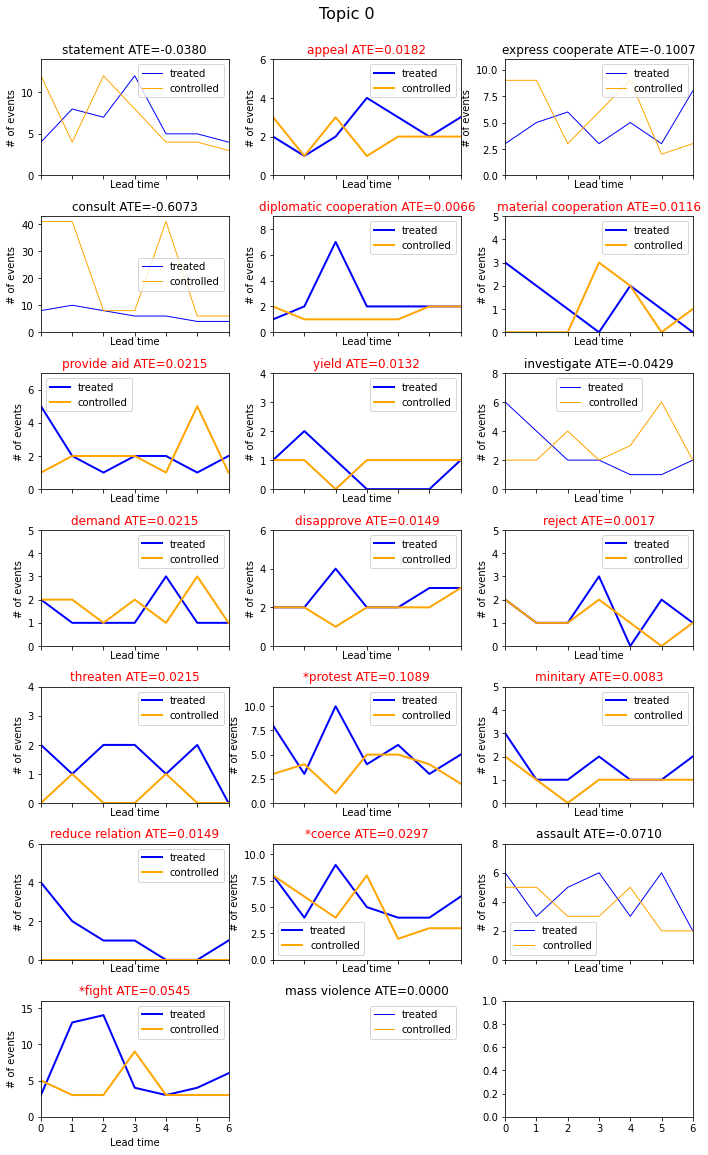

In [722]:
# from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt
# import matplotlib.colors as mcolors
%matplotlib inline

fig, axes = plt.subplots(7, 3, figsize=(10,16), sharex=True, sharey=False)
labels = ['statement', 'appeal','express cooperate','consult','diplomatic cooperation','material cooperation','provide aid','yield','investigate','demand','disapprove','reject','threaten','protest','minitary','reduce relation','coerce','assault','fight','mass violence']

for i, ax in enumerate(axes.flatten()):
    if i >= 20:
        break
#     if ATE[i] <= 0:
#         continue
    fig.add_subplot(ax)
    if ATE[i]>0:
        lw = 2
        title_color = 'red'
    else:
        lw = 1
        title_color = 'black'
    if i in top3:
        top = '*'
    else:
        top = ''
    ax.set_title(top+labels[i]+ ' ATE={:.4f}'.format(ATE[i]),color=title_color)

    ax.plot(all_treatment_outcome_day_max[:,i],label='treated',linewidth=lw,color='blue')#,marker='o')
    ax.plot(all_control_outcome_day_max[:,i],label='controlled',linewidth=lw,color='orange')
    max_y = max(all_control_outcome_day_max[:,i].max(), all_treatment_outcome_day_max[:,i].max()) + 2
    ax.set_ylim(0, max_y) 
    
    ax.margins(x=0, y=0)
    ax.set_ylabel('# of events')#, color=cols[i])
    ax.set_xlabel('Lead time')
    ax.legend()


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.suptitle('Topic '+str(topic_id), fontsize=16, y=1.0)  
plt.margins(x=0, y=0)
plt.legend()
plt.tight_layout()
# fig.savefig("topic-analysis/THA-wordcloud-50-1.pdf", bbox_inches='tight', dpi=300, transparent=True)
plt.show()

In [578]:
# cls.predict(covariate)
treatment_idices = treatment.nonzero()[0]
np.random.shuffle(treatment_idices)
treatment_idices

array([15,  1])

In [494]:
treatment.shape
raw_data_name = "raw_w10h7"
dataset = 'THA_topic'
out_path = '../data'

'201702' > '20170220'
from datetime import date
import datetime
startdate = date(2005, 2,1)#.strftime("%Y%d%m")
# days = date.DaysInMonth(year, month);
def last_day_of_month(any_day):
    # this will never fail
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)
    return next_month - datetime.timedelta(days=next_month.day)

last_day_of_month(startdate)

datetime.date(2005, 2, 28)

In [502]:
for topic_id in range(50):
    treatment_assign_by_topic = []
    covariate_by_topic = []
    outcome_by_topic = []
    out_file = "{}/{}/{}_topic_{}.pkl".format(out_path,dataset,raw_data_name.split('_')[1],topic_id)
#     print('out_file',out_file)
    for i in range(len(treatment)):
        curr_treament = treatment[i]
        past_treatment = treatment_check[i]
        if past_treatment[topic_id] <= 0:
            if curr_treament[topic_id] > 0: # treated sample
                treatment_assign_by_topic.append(1)
            else: # control sample
                treatment_assign_by_topic.append(0)
            covariate_by_topic.append(covariate[i])
            outcome_by_topic.append(outcome[i])
        else:
            pass
    treatment_assign_by_topic = np.array(treatment_assign_by_topic)
    n_smaple = len(treatment_assign_by_topic)
    n_treat =len(treatment_assign_by_topic.nonzero()[0])
    n_control = n_smaple-n_treat
    print('topic_id',topic_id,'n_treat =',n_treat,'n_control =',n_control,round(treatment_assign_by_topic.mean(),4))
    if n_treat < 30 or n_control < 30:
        continue
        
    outcome_by_topic = np.stack(outcome_by_topic,0)
    print('n_smaple',n_smaple,'outcome_by_topic',outcome_by_topic.shape)
    with open(out_file,'wb') as f:
        pickle.dump({'treatment':treatment_assign_by_topic,
                    'covariate':covariate_by_topic,
                    'outcome':outcome_by_topic},f)
    


topic_id 0 n_treat = 673 n_control = 2063 0.246
n_smaple 2736 outcome_by_topic (2736, 20)
topic_id 1 n_treat = 384 n_control = 4017 0.0873
n_smaple 4401 outcome_by_topic (4401, 20)
topic_id 2 n_treat = 397 n_control = 3688 0.0972
n_smaple 4085 outcome_by_topic (4085, 20)
topic_id 3 n_treat = 277 n_control = 3236 0.0788
n_smaple 3513 outcome_by_topic (3513, 20)
topic_id 4 n_treat = 595 n_control = 2753 0.1777
n_smaple 3348 outcome_by_topic (3348, 20)
topic_id 5 n_treat = 445 n_control = 2698 0.1416
n_smaple 3143 outcome_by_topic (3143, 20)
topic_id 6 n_treat = 487 n_control = 3632 0.1182
n_smaple 4119 outcome_by_topic (4119, 20)
topic_id 7 n_treat = 431 n_control = 3731 0.1036
n_smaple 4162 outcome_by_topic (4162, 20)
topic_id 8 n_treat = 327 n_control = 4183 0.0725
n_smaple 4510 outcome_by_topic (4510, 20)
topic_id 9 n_treat = 613 n_control = 1877 0.2462
n_smaple 2490 outcome_by_topic (2490, 20)
topic_id 10 n_treat = 506 n_control = 3124 0.1394
n_smaple 3630 outcome_by_topic (3630, 20)

In [309]:
# raw_covariate = data['covariate']
# raw_outcome = data['outcome']
# raw_covariate.shape, raw_outcome.shape
# raw_covariate[-1]
# a = [1,2,3,4,5,6,7,8
#     ]
# n=11
# a[-1],a[-n-1:-1]
text = [["a", "b", "c", "d","a"], ["a", "c", "d", "c"]]
from nltk.util import ngrams
text_bigrams = [ngrams(sent, 2) for sent in text]
text_unigrams = [ngrams(sent, 1) for sent in text]

In [310]:
# text_bigrams 
from nltk.lm import NgramCounter
ngram_counts = NgramCounter(text_bigrams + text_unigrams)

In [328]:
ngram_counts

In [366]:
# ngram_counts['a']
# sorted(ngram_counts[['']].items())
# from nltk import ngrams, FreqDist

# v = FreqDist(text_bigrams)
# v.most_common(1)

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
test_str1 = "I need to get most popular ngrams from text. Ngrams length must be from 1 to 5 words. Got it."
test_str2 = "I know how to exclude bigrams from trigrams, but i need better solutions. Good to know words. Got to do."


c_vec = TfidfVectorizer(ngram_range=(1, 2),stop_words='english', min_df=1)

# input to fit_transform() should be an iterable with strings
ngrams = c_vec.fit_transform([test_str1, test_str2])

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)
i = 0
# output n-grams
# for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
#     print(ng_count, ng_text)
#     i+=1
    
print(i)
sorted_tfidf_ngrams_tuple = sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
sorted_tfidf_ngrams = [a_tuple[1] for a_tuple in sorted_tfidf_ngrams_tuple]
sorted_tfidf_ngrams
    

0


['ngrams',
 'know',
 'words got',
 'words',
 'need',
 'got',
 'text ngrams',
 'text',
 'popular ngrams',
 'popular',
 'ngrams text',
 'ngrams length',
 'need popular',
 'length words',
 'length',
 'trigrams need',
 'trigrams',
 'solutions good',
 'solutions',
 'need better',
 'know words',
 'know exclude',
 'good know',
 'good',
 'exclude bigrams',
 'exclude',
 'bigrams trigrams',
 'bigrams',
 'better solutions',
 'better']

In [349]:
count_values

array([0.18249823, 0.18249823, 0.18249823, 0.18249823, 0.18249823,
       0.18249823, 0.18249823, 0.18249823, 0.18249823, 0.18249823,
       0.18249823, 0.18249823, 0.28502058, 0.36499647, 0.18249823,
       0.18249823, 0.18249823, 0.18249823, 0.21808824, 0.21808824,
       0.21808824, 0.28502058, 0.18249823, 0.18249823, 0.21808824,
       0.21808824, 0.43617648, 0.21808824, 0.21808824, 0.21808824,
       0.21808824, 0.21808824, 0.21808824, 0.21808824, 0.18249823,
       0.18249823, 0.18249823, 0.21808824, 0.21808824, 0.21808824,
       0.18249823, 0.18249823, 0.18249823, 0.28502058, 0.28502058])

In [401]:
# ngram_counts['a']
# sorted(ngram_counts[['']].items())
# from nltk import ngrams, FreqDist

# v = FreqDist(text_bigrams)
# v.most_common(1)

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
test_str1 = "I need to get most popular ngrams from text. Ngrams length must be from 1 to 5 words. Got it."
test_str2 = "I know how to exclude bigrams from trigrams, but i need better solutions. Good to know words. Got to do."
test_str1 = test_str1.split(' ')
test_str2 = test_str2.split(' ')
print(test_str2)
c_vec = CountVectorizer(ngram_range=(1, 2),stop_words='english', lowercase=False, tokenizer=lambda x: x,binary=False,vocabulary=['words','got','know','need','ngrams','must'])#,vocabulary=['need','ngrams','must'])
# c_vec = CountVectorizer(ngram_range=(1, 2),stop_words='english',binary=False,vocabulary=['words','got','know','need','ngrams','must'])

# input to fit_transform() should be an iterable with strings
ngrams_vec = c_vec.fit_transform([test_str1, test_str2])

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_
print(vocab)
count_values = ngrams.toarray().sum(axis=0)
i = 0
# output n-grams
# for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
#     print(ng_count, ng_text)
#     i+=1
    
# print(i)

# type(ngrams_vec)
# ngrams_vec
{'words': 0, 'got': 1, 'know': 2, 'need': 3, 'ngrams': 4, 'must': 5}
np.array([[0, 0, 0, 1, 1, 0],
       [0, 0, 2, 1, 0, 0]])
# token
{'words': 0, 'got': 1, 'know': 2, 'need': 3, 'ngrams': 4, 'must': 5}
np.array([[1, 1, 0, 1, 2, 0],
       [1, 1, 2, 1, 0, 0]])
ngrams_vec.toarray()


['I', 'know', 'how', 'to', 'exclude', 'bigrams', 'from', 'trigrams,', 'but', 'i', 'need', 'better', 'solutions.', 'Good', 'to', 'know', 'words.', 'Got', 'to', 'do.']
{'words': 0, 'got': 1, 'know': 2, 'need': 3, 'ngrams': 4, 'must': 5}


array([[0, 0, 0, 1, 1, 0],
       [0, 0, 2, 1, 0, 0]])

In [369]:
from sklearn.feature_extraction.text import HashingVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = HashingVectorizer(n_features=2**4)
X = vectorizer.fit_transform(corpus)
print(X.shape)
X.toarray()


(4, 16)


array([[-0.57735027,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.57735027,  0.        ,
         0.        ,  0.        ,  0.        ,  0.57735027,  0.        ,
         0.        ],
       [-0.81649658,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.40824829,  0.        ,  0.40824829,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.70710678,
         0.70710678,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.57735027,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.57735027,  0.        ,
         0.        ,  0.        ,  0.        ,  0.57735027,  0.        ,
         0.        ]])

In [495]:
a = [1,2,3]
a.pop()
a

[1, 2]